# Load Libraries

In [1]:
import os
current = os.getcwd()
os.chdir("../")

In [68]:
import pandas as pd
import talib
import numpy as np #computing multidimensionla arrays
import datetime
import urllib3
import time
import settings
from tqdm import tqdm

In [69]:
os.chdir(current)

## logging

In [8]:
import logging

# logging.basicConfig(filename='null',format='%(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

#create a file handler
handler = logging.FileHandler('/tmp/logfile.log')
handler.setLevel(logging.INFO)


In [9]:
title = logging.Formatter('%(message)s')
handler.setFormatter(title)

# add the handlers to the logger
logger.addHandler(handler)


## Load binance libraries

In [11]:
from binance.client import Client
api_key = settings.api_key
api_secret = settings.api_secret
client = Client(api_key, api_secret)

# StochasticRSI Function
def Stoch(close,high,low, smoothk, smoothd, n):
    lowestlow = pd.Series.rolling(low,window=n,center=False).min()
    highesthigh = pd.Series.rolling(high, window=n, center=False).max()
    K = pd.Series.rolling(100*((close-lowestlow)/(highesthigh-lowestlow)), window=smoothk).mean()
    D = pd.Series.rolling(K, window=smoothd).mean()
    return K, D


## Get the historical data

The get_historical_klines function will take a while probably it's better to paginate it ToDo

In [12]:
start_date = "1 Apr, 2021"

In [39]:
#     # Get Binance Data into dataframe
#     # candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1MINUTE)
candles = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, start_date)

The operations below set the names for the columns in the dataframe

In [70]:
df = pd.DataFrame(candles)
df.columns=['timestart','open','high','low','close','?','timeend','?','?','?','?','?']

In [103]:
final_df = pd.DataFrame(columns = ["candlestart", "candleend", "candleclose", "candleRSI", "candleK", "candleD"])

In [104]:
# for i in tqdm(range(0, len(df)-500 + 1)):
for i in tqdm(range(0, 10000 + 1)):
    start = i
    end = i + 500 - 1
    current_df = df[start:end]
    
    # The operation below translates the timestamps into datetime format
    current_df.timestart = [datetime.datetime.fromtimestamp(i/1000) for i in current_df.timestart.values]
    current_df.timeend = [datetime.datetime.fromtimestamp(i/1000) for i in current_df.timeend.values]
    
    # This seems to be computing the RSI
    float_data = [float(x) for x in current_df.close.values]
    np_float_data = np.array(float_data)
    rsi = talib.RSI(np_float_data, 14)
    current_df['rsi'] = rsi

    # Compute StochRSI using RSI values in Stochastic function
    mystochrsi = Stoch(current_df.rsi, current_df.rsi, current_df.rsi, 3, 3, 14)
    current_df['MyStochrsiK'], current_df['MyStochrsiD'] = mystochrsi

    newestcandlestart = current_df.timestart.astype(str).iloc[-1] #gets last time
    newestcandleend = current_df.timeend.astype(str).iloc[-1] #gets current time?
    newestcandleclose = current_df.close.astype(float).iloc[-1] #gets last close
    newestcandleRSI = current_df.rsi.astype(float).iloc[-1] #gets last rsi
    newestcandleK = current_df.MyStochrsiK.astype(float).iloc[-1] #gets last rsi
    newestcandleD = current_df.MyStochrsiD.astype(float).iloc[-1] #gets last rsi
    
    row = [ newestcandlestart, newestcandleend, newestcandleclose, newestcandleRSI, newestcandleK, newestcandleD ]
    
    final_df.loc[i] = row

  0%|          | 0/10001 [00:00<?, ?it/s]<ipython-input-104-9ba7f32c0bcf>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['rsi'] = rsi
<ipython-input-104-9ba7f32c0bcf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['MyStochrsiK'], current_df['MyStochrsiD'] = mystochrsi
100%|██████████| 10001/10001 [02:48<00:00, 59.38it/s]


In [105]:
final_df

,candlestart,candleend,candleclose,candleRSI,candleK,candleD
0,2021-04-01 08:18:00,2021-04-01 08:18:59.999,59184.56,75.471627,100.000000,100.000000
1,2021-04-01 08:19:00,2021-04-01 08:19:59.999,59192.14,75.898008,100.000000,100.000000
2,2021-04-01 08:20:00,2021-04-01 08:20:59.999,59213.55,77.108432,100.000000,100.000000
3,2021-04-01 08:21:00,2021-04-01 08:21:59.999,59299.97,81.210337,100.000000,100.000000
4,2021-04-01 08:22:00,2021-04-01 08:22:59.999,59393.04,84.443343,100.000000,100.000000
...,...,...,...,...,...,...
9996,2021-04-08 06:54:00,2021-04-08 06:54:59.999,57039.00,41.112199,0.724819,11.227457
9997,2021-04-08 06:55:00,2021-04-08 06:55:59.999,57044.98,42.715858,4.653921,4.645084
9998,2021-04-08 06:56:00,2021-04-08 06:56:59.999,57142.58,61.259221,37.987255,14.455332
9999,2021-04-08 06:57:00,2021-04-08 06:57:59.999,57098.97,53.003096,57.660794,33.433990


## Plot the lines

In [106]:
import matplotlib.pyplot as plt
# import seaborn as sns

<AxesSubplot:>

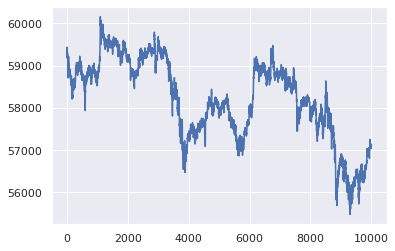

In [107]:
final_df.candleclose.plot()

<AxesSubplot:>

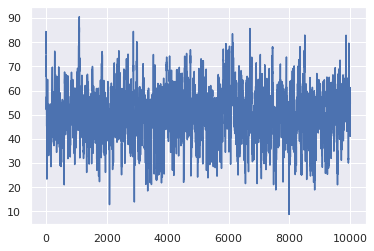

In [108]:
final_df.candleRSI.plot()

## Questions

 - What is the time step to use for RSI? At the moment we are using a minute, but possibly that's not a good indicator, we might need to use 15 minutes

## Playing with the TA-lib

In [112]:
final_df[:10]

,candlestart,candleend,candleclose,candleRSI,candleK,candleD
0,2021-04-01 08:18:00,2021-04-01 08:18:59.999,59184.56,75.471627,100.000000,100.000000
1,2021-04-01 08:19:00,2021-04-01 08:19:59.999,59192.14,75.898008,100.000000,100.000000
2,2021-04-01 08:20:00,2021-04-01 08:20:59.999,59213.55,77.108432,100.000000,100.000000
3,2021-04-01 08:21:00,2021-04-01 08:21:59.999,59299.97,81.210337,100.000000,100.000000
4,2021-04-01 08:22:00,2021-04-01 08:22:59.999,59393.04,84.443343,100.000000,100.000000
5,2021-04-01 08:23:00,2021-04-01 08:23:59.999,59252.60,65.991448,77.908083,92.636028
6,2021-04-01 08:24:00,2021-04-01 08:24:59.999,59292.28,68.111631,56.287422,78.065169
7,2021-04-01 08:25:00,2021-04-01 08:25:59.999,59284.64,67.242401,33.163768,55.786425
8,2021-04-01 08:26:00,2021-04-01 08:26:59.999,59437.70,74.314580,36.958083,42.136425
9,2021-04-01 08:27:00,2021-04-01 08:27:59.999,59435.58,74.076031,39.850204,36.657352


In [114]:
talib.STOCHRSI(final_df[:53].candleclose)

(0            NaN
 1            NaN
 2            NaN
 3            NaN
 4            NaN
 5            NaN
 6            NaN
 7            NaN
 8            NaN
 9            NaN
 10           NaN
 11           NaN
 12           NaN
 13           NaN
 14           NaN
 15           NaN
 16           NaN
 17           NaN
 18           NaN
 19           NaN
 20     34.394462
 21      0.000000
 22      0.000000
 23      0.000000
 24     66.224859
 25      0.000000
 26     29.900208
 27     39.774296
 28      2.555052
 29      0.000000
 30      0.000000
 31     99.325952
 32      0.000000
 33      0.000000
 34      2.335512
 35     25.413392
 36     49.497202
 37    100.000000
 38    100.000000
 39     56.804717
 40    100.000000
 41     84.993125
 42    100.000000
 43     81.477784
 44     56.904384
 45     26.074235
 46    100.000000
 47     31.205939
 48    100.000000
 49    100.000000
 50    100.000000
 51    100.000000
 52     55.738682
 dtype: float64,
 0              NaN
 1       

In [118]:
talib.MACD(final_df[:50].candleclose)

(0            NaN
 1            NaN
 2            NaN
 3            NaN
 4            NaN
 5            NaN
 6            NaN
 7            NaN
 8            NaN
 9            NaN
 10           NaN
 11           NaN
 12           NaN
 13           NaN
 14           NaN
 15           NaN
 16           NaN
 17           NaN
 18           NaN
 19           NaN
 20           NaN
 21           NaN
 22           NaN
 23           NaN
 24           NaN
 25           NaN
 26           NaN
 27           NaN
 28           NaN
 29           NaN
 30           NaN
 31           NaN
 32           NaN
 33    -85.081271
 34   -109.703077
 35   -122.482519
 36   -131.216356
 37   -135.722964
 38   -131.571014
 39   -132.364432
 40   -126.088227
 41   -121.780224
 42   -110.649791
 43   -103.275352
 44    -97.319477
 45    -94.066532
 46    -84.632954
 47    -81.509747
 48    -72.884901
 49    -63.639282
 dtype: float64,
 0            NaN
 1            NaN
 2            NaN
 3            NaN
 4         